In [41]:
import pandas as pd
import numpy as np

import datetime as dt

import time

import psycopg2 as pg
from sshtunnel import SSHTunnelForwarder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
    
sns.set('talk', 'darkgrid', 'dark', font_scale=1.,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

# センサデータを用いた時系列解析

## 1. 環境センサのデータを選択し，sensor名ごとにカラムを作る
- SQL文を工夫して必要なデータのみ取得して解析しよう
    - センサ名
    - 期間の指定

### (1) AmbientLightデータのみ取得

In [57]:
with pg.connect(host="sakuma-linux", port="12346", dbname="postgres", user="docker", password="password"
)as conn:
    with conn.cursor('cursor') as cursor:
        cursor.execute("select time, value from alps where sensor='{0}' and \
        time between '2018-03-12' and '2018-03-13'".format("AmbientLight"))
        db = cursor.fetchall()
df = pd.DataFrame(db)
df.columns = ['Time', 'AmbientLight']
df.index = df.Time
df = df.drop(['Time'], axis=1)
df['AmbientLight'] = df['AmbientLight'].astype('float')

In [58]:
df

,AmbientLight
Time,
2018-03-12 00:00:02+00:00,0.000
2018-03-12 00:00:05+00:00,21.552
2018-03-12 00:00:07+00:00,0.000
2018-03-12 00:00:10+00:00,0.000
2018-03-12 00:00:12+00:00,43.103
2018-03-12 00:00:14+00:00,0.000
2018-03-12 00:00:16+00:00,0.000
2018-03-12 00:00:18+00:00,0.000
2018-03-12 00:00:21+00:00,43.103


### (2) 環境センサ全てのデータを取得
- 各センサのデータをそれぞれ取得し，DataFrame"alps_data"にjoin関数を用いて結合する

In [10]:
def fetch_db(sensor_name):
    with pg.connect(host="sakuma-linux", port="1234", dbname="postgres", user="postgres", password="password"
    )as conn:
        with conn.cursor('cursor') as cursor:
            cursor.execute("select time, value from alps where sensor='{0}'".format(sensor_name))#時間指定足す
            db = cursor.fetchall()
    df = pd.DataFrame(db)
    df.columns = ["Time", sensor_name]
    df.index = df.Time
    df = df.drop(["Time"], axis=1)
    df[sensor_name] = df[sensor_name].astype('float')
    return df

In [50]:
names = ['Pressure', 'Humidity', 'Temperature', 'UV', 'AmbientLight']
alps_data = fetch_db(names[0])
for i in range(1, len(names)):
    tmp = fetch_db(names[i])
    alps_data = alps_data.join(tmp)

In [59]:
alps_data

,Pressure,Humidity,Temperature,UV,AmbientLight
Time,,,,,
2018-03-02 10:23:50+00:00,989.625,36.984,20.0,0.052,150.862
2018-03-02 10:23:51+00:00,989.572,37.031,20.0,0.000,86.207
2018-03-02 10:23:53+00:00,1003.509,29.328,18.0,0.232,280.172
2018-03-02 10:23:54+00:00,1003.483,29.422,18.0,0.232,301.724
2018-03-02 10:23:56+00:00,1003.535,29.359,18.0,0.258,301.724
2018-03-02 10:23:58+00:00,1003.535,29.391,18.0,0.284,301.724
2018-03-02 10:23:59+00:00,1003.483,29.344,18.0,0.232,301.724
2018-03-02 10:24:01+00:00,1003.509,29.375,18.0,0.258,301.724
2018-03-02 10:24:03+00:00,1003.561,29.453,18.0,0.232,344.828


## 2. 取得したデータの保存
データベースから取得したデータをcsv形式で保存しよう
- csv形式にして出力

In [60]:
alps_data.to_csv("alps_data.csv")

## 3. データの選択と加工

### (1) 特定の日付のデータを取得

In [129]:
alps_data['2018-02-28']

,Pressure,Humidity,Temperature,UV,AmbientLight
Time,,,,,
2018-02-28 14:58:19,1016.763,26.797,24.0,0.129,301.724
2018-02-28 14:58:21,1016.723,27.344,24.0,0.103,301.724
2018-02-28 14:58:22,1016.723,27.359,NaN,NaN,NaN
2018-02-28 15:00:09,1016.697,27.359,24.0,0.155,258.621
2018-02-28 15:00:11,1016.723,27.453,24.0,0.077,215.517
2018-02-28 15:00:13,1016.671,27.391,24.0,0.052,258.621
2018-02-28 15:00:14,1016.671,27.453,24.0,0.077,258.621
2018-02-28 15:00:16,1016.671,27.453,24.0,0.000,215.517
2018-02-28 15:00:17,1016.645,27.391,24.0,0.129,258.621


### (2) 時間指定

In [130]:
alps_data['2018-02-28 14:00':'2018-02-28 15:00']

,Pressure,Humidity,Temperature,UV,AmbientLight
Time,,,,,
2018-02-28 14:58:19,1016.763,26.797,24.0,0.129,301.724
2018-02-28 14:58:21,1016.723,27.344,24.0,0.103,301.724
2018-02-28 14:58:22,1016.723,27.359,NaN,NaN,NaN
2018-02-28 15:00:09,1016.697,27.359,24.0,0.155,258.621
2018-02-28 15:00:11,1016.723,27.453,24.0,0.077,215.517
2018-02-28 15:00:13,1016.671,27.391,24.0,0.052,258.621
2018-02-28 15:00:14,1016.671,27.453,24.0,0.077,258.621
2018-02-28 15:00:16,1016.671,27.453,24.0,0.000,215.517
2018-02-28 15:00:17,1016.645,27.391,24.0,0.129,258.621


### (3) リサンプリングと頻度変換
- 時系列をある頻度から別の頻度に変換する
    - ダウンサンプリング：高い頻度のデータを低い頻度のデータへ
    - アップサンプリング：低い頻度のデータを高い頻度のデータへ
- resampleメソッド

In [132]:
#１分間隔でリサンプリング
alps_data.resample('T').mean()

,Pressure,Humidity,Temperature,UV,AmbientLight
Time,,,,,
2018-02-28 14:58:00,1016.736333,27.166667,24.0,0.116000,301.724000
2018-02-28 14:59:00,NaN,NaN,NaN,NaN,NaN
2018-02-28 15:00:00,1016.676656,27.396469,24.0,0.117226,270.115033
2018-02-28 15:01:00,1016.649083,27.389686,24.0,0.084912,246.865182
2018-02-28 15:02:00,1016.646050,27.352400,24.0,0.110571,260.160000
2018-02-28 15:03:00,1016.638143,27.363857,24.0,0.184526,238.416000
2018-02-28 15:04:00,1016.633087,27.351913,24.0,0.111571,257.543000
2018-02-28 15:05:00,1016.626037,27.375667,24.0,0.149909,269.396636
2018-02-28 15:06:00,1016.602500,27.380966,24.0,0.110000,252.334750


- Open-high-Low-Close(OHLC)再サンプリング
    - 最初の値(open), 最後の値(close),最大値(high),最小値(low)の４つの列を持つデータフレームを取得

In [134]:
alps_data.resample('D').ohlc()

Pressure                               Humidity                  \
                open      high       low     close     open    high     low   
Time                                                                          
2018-02-28  1016.763  1016.763  1016.343  1016.382   26.797  28.031  26.797   

                   Temperature                       UV                    \
             close        open  high   low close   open   high  low close   
Time                                                                        
2018-02-28  27.891        24.0  24.0  23.0  23.0  0.129  1.366  0.0   0.0   

           AmbientLight                         
                   open     high  low    close  
Time                                            
2018-02-28      301.724  991.379  0.0  193.966

### (4) 欠損値の処理

- 欠損のある行を削除する

In [135]:
alps_data.dropna()

,Pressure,Humidity,Temperature,UV,AmbientLight
Time,,,,,
2018-02-28 14:58:19,1016.763,26.797,24.0,0.129,301.724
2018-02-28 14:58:21,1016.723,27.344,24.0,0.103,301.724
2018-02-28 15:00:09,1016.697,27.359,24.0,0.155,258.621
2018-02-28 15:00:11,1016.723,27.453,24.0,0.077,215.517
2018-02-28 15:00:13,1016.671,27.391,24.0,0.052,258.621
2018-02-28 15:00:14,1016.671,27.453,24.0,0.077,258.621
2018-02-28 15:00:16,1016.671,27.453,24.0,0.000,215.517
2018-02-28 15:00:17,1016.645,27.391,24.0,0.129,258.621
2018-02-28 15:00:19,1016.671,27.469,24.0,0.129,280.172


- ダウンサンプリングして前方または後方に穴埋めする

In [137]:
alps_data.resample('T').mean().bfill()

,Pressure,Humidity,Temperature,UV,AmbientLight
Time,,,,,
2018-02-28 14:58:00,1016.736333,27.166667,24.0,0.116000,301.724000
2018-02-28 14:59:00,1016.676656,27.396469,24.0,0.117226,270.115033
2018-02-28 15:00:00,1016.676656,27.396469,24.0,0.117226,270.115033
2018-02-28 15:01:00,1016.649083,27.389686,24.0,0.084912,246.865182
2018-02-28 15:02:00,1016.646050,27.352400,24.0,0.110571,260.160000
2018-02-28 15:03:00,1016.638143,27.363857,24.0,0.184526,238.416000
2018-02-28 15:04:00,1016.633087,27.351913,24.0,0.111571,257.543000
2018-02-28 15:05:00,1016.626037,27.375667,24.0,0.149909,269.396636
2018-02-28 15:06:00,1016.602500,27.380966,24.0,0.110000,252.334750


## 4. データの可視化

### (1) センサごとに表示
- dropna()で欠損値を省く

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8021162c88>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8020aa8b70>], dtype=object)

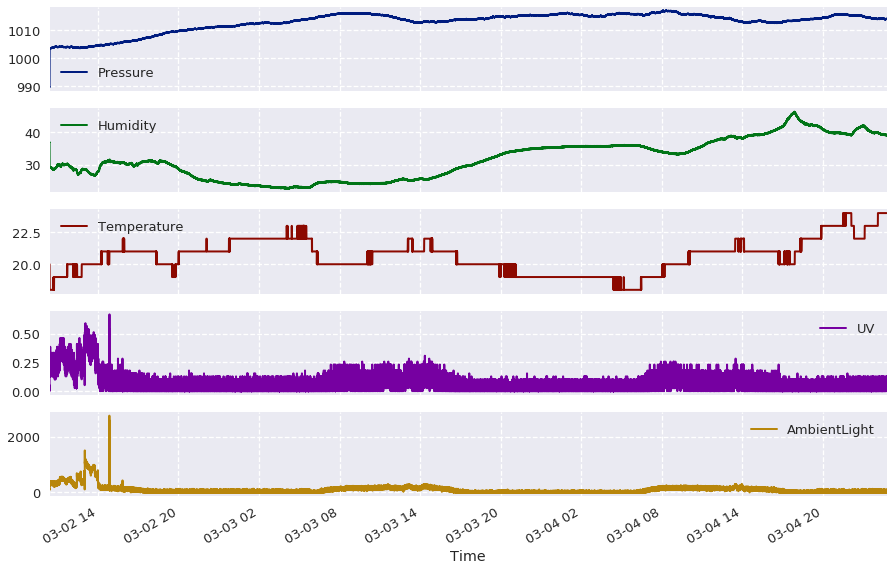

In [52]:
alps_data.dropna().plot(subplots=True, figsize=(15, 10))

### (2) 移動する窓関数
- 窓関数を移動させながらデータを評価する
- 例えば欠損があるデータや粗いデータなどに適用
    - rolling関数

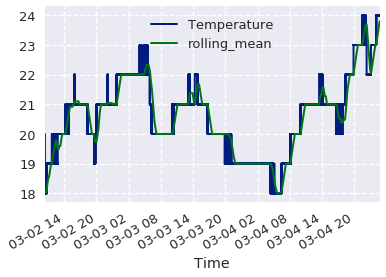

In [53]:
#移動平均(rolling mean)
alps_data['Temperature'].plot()
alps_data['Temperature'].resample('T').mean().bfill().rolling(window=50, min_periods=10).mean().plot(label='rolling_mean')
plt.legend()

### (3) 2軸グラフ

In [55]:
data = alps_data.resample('T').mean().bfill()

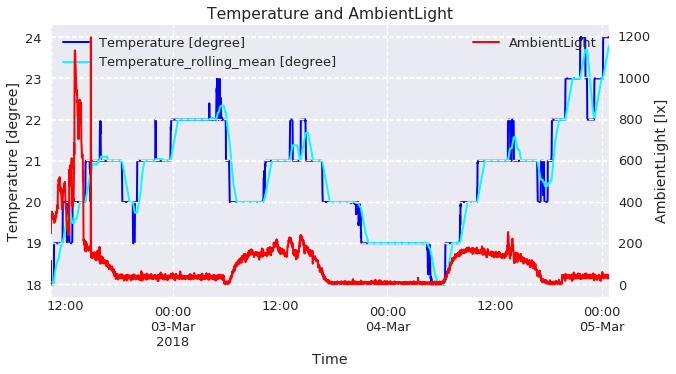

In [56]:
ax = data['Temperature'].plot(label='Temperature [degree]', color='blue', figsize=(10, 5))
data['Temperature'].rolling(window=50, min_periods=10).mean().plot(label='Temperature_rolling_mean [degree]', color='cyan')
plt.legend(loc=2)
plt.ylabel('Temperature [degree]')
plt.xlabel('Time')
ax2 = ax.twinx()
data['AmbientLight'].plot(ax=ax2,color='red')
plt.legend(loc=1)
plt.ylabel('AmbientLight [lx]')
plt.title('Temperature and AmbientLight')